<a href="https://colab.research.google.com/github/CeliaDiazSanchez/Data-Mining/blob/LAB02/LAB02_p1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**LABORATORIO 2**
**Grupo**: B01

**Integrantes**: Claudia Esnarrizaga, Ana Robledano, Celia Díaz, Julia Callaba

## **PRÁCTICA 1 (Reglas de Asociación)**

##**Enunciado**

Usa la librería `mlxtend` que nos permita solucionar todos los problemas relacionados con las reglas de
asociación. Para ello tendremos que usar el algoritmo Apriori y una serie de métodos para obtener la distinta
información que este genera.

Usaremos la librería con el Dataset **Market_Basket_Optimisation.csv** que se ha proporcionado.

Prueba al menos tres configuraciones de soporte y frecuencia para cada tipo de puntuación.

Importamos las librerías necesarias y el archivo.

In [1]:
import requests
import warnings
import pandas as pd
import numpy as np
import plotly.express as px
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules
import networkx as nx
import matplotlib.pyplot as plt

# URL del archivo CSV en GitHub
url = "https://raw.githubusercontent.com/CeliaDiazSanchez/Data-Mining/LAB02/Market_Basket_Optimisation.csv"
nombre = 'Market_Basket_Optimisation.csv'


# Realizar la solicitud GET para obtener el contenido del archivo
response = requests.get(url)

# Verificar si la solicitud fue exitosa (código de estado 200)
if response.status_code == 200:
     # Guardar el contenido del archivo en un archivo local
    with open(nombre, 'wb') as f:
        f.write(response.content)
    print("Archivo descargado exitosamente.")
else:
    print("Error al descargar el archivo.")

Archivo descargado exitosamente.


Cargamos el archivo de Market_Basket_Optimisation CSV en un DataFrame de pandas que llamamos ds.

In [2]:
ds = pd.read_csv('Market_Basket_Optimisation.csv')
# Mostramos las 5 primeras entradas del dataset
ds.head(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
0,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,low fat yogurt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Exploración y limpieza de la base de datos

Si vemos la base de datos, parece corrupta porque tiene muchos NaNs y sale que el título de cada columna es un alimento. Pero al abrir la base de datos en su formato original, observamos que en realidad son filas con la lista de la compra de 7501 personas.

Por ello, no tenemos que limpiar nada, ya que esos NaNs no nos están sesgando, simplemente delimitan la información.

Estas serían las 10 entradas líneas de nuestra base de datos:
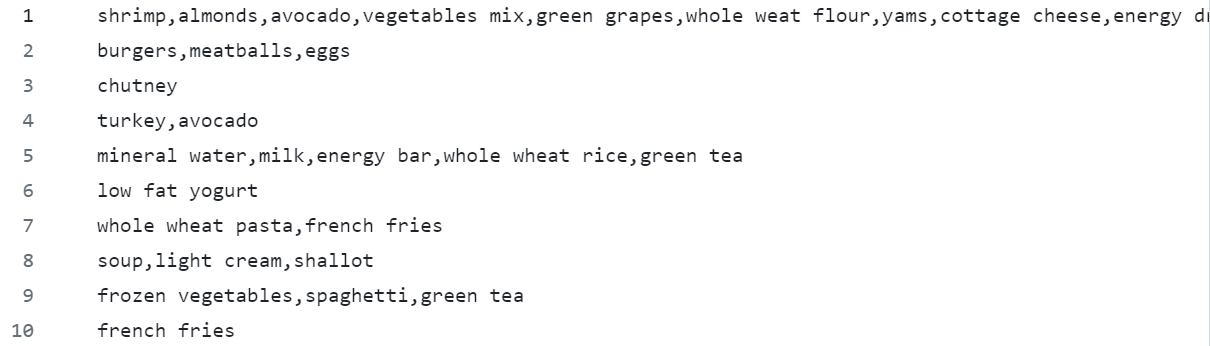

Se trata de una base de datos con listas de compras de productos de supermercado.

In [5]:
ds.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(7500, 20)

Tiene `7501` **filas** (más 1 de la fila de etiquetas de columna que conforma una compra más). Y `20` **columnas** pero que no aportan ninguna información ya que los elementos son productos ordenados.

Queremos registrar todos los productos en una lista para estudiarlos posteriormente.

In [107]:
# Inicializamos la lista de nombres de productos
transacciones = []
# Guardamos en una lista los elementos Del dataFrame
# Las etiquetas de columna (que representan la primera transacción) + Resto de productos en el DataFrame
transacciones = ds.columns.tolist()
transacciones = transacciones  + ds.stack().tolist()

El método `stack()` en pandas se utiliza para "apilar" los niveles de columna en un DataFrame, lo que significa que convierte las columnas en el nivel más interno del índice. Antes hemos transpuesto el DataFrame para que lo recorra por filas y no por columnas, así se mantiene el orden de las transacciones, aunque para el caso de contar las frecuencias con `k=1` el orden no importará.

En resumen, `ds.T.stack().tolist()` toma un DataFrame, lo transpone para que las filas se conviertan en columnas y viceversa, apila todas las columnas convertidas en filas, elimina cualquier fila que contenga un valor NaN y finalmente convierte los valores en una lista de Python.







Como son muchos datos (7501 filas con varios elementos cada una), sale un warning de la librería numpy que vamos a ignorar.

In [95]:
warnings.filterwarnings('default')

Mostramos las primeras 25 compras.

In [108]:
transacciones[:25]

['shrimp',
 'almonds',
 'avocado',
 'vegetables mix',
 'green grapes',
 'whole weat flour',
 'yams',
 'cottage cheese',
 'energy drink',
 'tomato juice',
 'low fat yogurt',
 'green tea',
 'honey',
 'salad',
 'mineral water',
 'salmon',
 'antioxydant juice',
 'frozen smoothie',
 'spinach',
 'olive oil',
 'burgers',
 'meatballs',
 'eggs',
 'chutney',
 'turkey']

Comprobamos que la lista obtenida coincide con los valores del DataFrame ignorando los NaNs.

In [97]:
ds.head(3)

,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
0,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Contamos con `29362` productos comprados. Recordamos que pueden repetirse entre las transacciones.

In [98]:
len(transacciones)

29363

Y `120` productos únicos.

In [46]:
len(set(transacciones))

120

Para evitar errores de transcripción, como el mismo producto escrito en mayúsculas, pasamos todos los elementos de la lista a minúsculas.

In [47]:
# Convertir todos los elementos a minúsculas
transacciones = [elemento.lower() for elemento in transacciones]

## **Resolución**

Instalamos la librería `mlxtend`. Esta librería se utiliza comúnmente para extender las capacidades de otras bibliotecas populares de machine learning, como scikit-learn.

In [48]:
!pip install mlxtend

Anteriormente hemos filtrado los datos y los hemos introducimos en una lista para aplicar el algoritmo Apriori.

Es necesario tener las transacciones en un array unidimensional porque el algoritmo Apriori de `mlxtend` espera un conjunto de transacciones, donde cada transacción es una lista de elementos.

In [49]:
transacciones = np.array(transacciones)

In [50]:
print(transacciones)

['shrimp' 'almonds' 'avocado' ... 'frozen smoothie' 'yogurt cake'
 'low fat yogurt']


###**Preprocesamiento y análisis exploratorio de datos**

#### **k = 1**

**1. Creación del DataFrame inicial:**

Contiene todos los productos.

In [51]:
df = pd.DataFrame(transacciones, columns=["items"])

**2. Eliminar filas con valor "nan" en la columna 'items'**

En este caso, como ya hemos filtrado los datos anteriormente, no hay ningún NaN que eliminar.

In [52]:
cantidad_nans = df.isna().sum().sum()
if cantidad_nans != 0:
  indexNames = df[df['items'] == "nan" ].index
  df.drop(indexNames , inplace=True)
  print('Se eliminaron los NaNs')
else:
  print('No hay NaNs en el data frame')

No hay NaNs en el data frame


**3. Agrupar y contar la frecuencia de cada elemento ('items'):**

Con `value_counts()` se cuenta la frecuencia de cada valor único en el DataFrame original.

In [73]:
df.value_counts()

items        
mineral water    1788
eggs             1348
spaghetti        1306
french fries     1282
chocolate        1230
                 ... 
bramble            14
cream               7
napkins             5
water spray         3
 asparagus          1
Length: 120, dtype: int64

Usaremos esta función y reorganizaremos los resultados en un nuevo DataFrame (df_table) con dos columnas: una columna que contiene los valores únicos y otra columna que contiene la frecuencia de cada valor único.

In [70]:
df_table = df.value_counts().reset_index().rename(columns={ 0: "Frecuencia soporte"})
# .reset_index(): resetea el índice de la Serie resultante de value_counts() para convertir los índices en una nueva columna del DataFrame
# .rename(): la columna de frecuencia se renombra como "Frecuencia soporte" para mayor claridad

Obtenemos un DataFrame con 2 columnas, para el nombre del producto y su frecuencia y 120 entradas para cada producto (único).

In [74]:
df_table.shape

(120, 2)

**4. Visualización de las primeras 10 frecuencias con estilo de degradado de color:**

In [75]:
df_table.head(10).style.background_gradient(cmap='Blues')

,items,Frecuencia soporte
0,mineral water,1788
1,eggs,1348
2,spaghetti,1306
3,french fries,1282
4,chocolate,1230
5,green tea,991
6,milk,972
7,ground beef,737
8,frozen vegetables,715
9,pancakes,713


Cada línea muestra un elemento y la cantidad de veces que aparece en las transacciones. Está ordenado de mayor a menor, siendo **"mineral water"** el elemento que más aparece en las transacciones y *asparagus* el que menos (solamente aparece una vez).

A continuación lo mostraremos usando un `treemap interactivo` para visualizar la frecuencia de los 60 elementos con la mayor frecuencia en el conjunto de datos.

In [76]:
# Desactivamos los warnings
warnings.filterwarnings('ignore')

df_table["all"] = "60 items that have highest freqs"

fig = px.treemap(df_table.head(60), path=['all', "items"], values='Frecuencia soporte',
                  color=df_table["Frecuencia soporte"].head(60), hover_data=['items'],
                  color_continuous_scale='Blues',
                )

fig.show()

# Volvemos a activar los warnings
warnings.filterwarnings('default')

Eliminamos la columna auxiliar que usamos para el `treemap`.

In [88]:
df_table = df_table.drop(columns='all')

Observamos que los productos más frecuentes después del agua son los huevos, spaghetti, patatas fritas y el chocolate.  Sin embargo el producto "pasta" que podría englobar los spaguettis tiene una frecuencia muy baja. Y esto puede causar imprecisiones.

In [92]:
ds[(ds['items'] == 'pasta') | (ds['items'] == 'spaghetti')]

,items,Frecuencia soporte
2,spaghetti,1306
59,pasta,118


Como los spaguetti es un tipo de pasta, consideramos que sería más interesante agrupar esos 2 items como uno solo. Ya que el supermercado debería colocar todos los productos de pasta en el mismo sitio.

Por ejemplo, si obtuviésemos una regla del tipo `spaghetti -> pancakes`, querríamos colocar los spaghettis cerca de los pancakes, y los otros tipos de pasta también deberían estar en el mismo sitio que los spaghetti para mayor comodidad y eficiencia logística.

In [100]:
ds.replace('spaghetti','pasta', inplace=True)

#### **k = 2**

Realizamos el mismo proceso para k = 2. Ahora nuestra lista de transacciones será una lista de listas, con las combinaciones de los elementos anteriores.

In [109]:
# Desactivamos los warnings
warnings.filterwarnings('ignore')

k2_transacciones = []

i = 0
while i < ds.shape[0]:
    k2_transacciones.append([str(ds.values[i, j]) for j in range(ds.shape[1])])
    i += 1

k2_transacciones = np.array(k2_transacciones)

# Volvemos a activar los warnings
warnings.filterwarnings('default')

KeyboardInterrupt: 

`TransactionEncoder` es una herramienta de la librería `mlxtend` diseñada para convertir una lista de transacciones en una matriz binaria.

En esta matriz, cada columna corresponde a un item, y cada fila representa una transacción, con valores binarios indicando la presencia o ausencia de cada item en dicha transacción.

El proceso de ajuste y transformación se realiza mediante la combinación de `te.fit(transacciones).transform(transacciones)`, donde se ajusta el `TransactionEncoder` a las transacciones y se transforman en una matriz binaria.

Posteriormente, crearemos un DataFrame de pandas (`pd.DataFrame`) con la matriz binaria transformada, utilizando las etiquetas originales de los items como nombres de columnas. La visualización de las primeras filas del DataFrame mediante `ds.head()` nos permite inspeccionar la estructura y contenido de la matriz binaria resultante.

In [ ]:
TE = TransactionEncoder()

# Ajustar y transformar las transacciones usando TransactionEncoder
matriz = TE.fit(k2_transacciones).transform(k2_transacciones)

# Crear un DataFrame con la matriz transformada y columnas etiquetadas
ds = pd.DataFrame(matriz, columns = TE.columns_)

# Mostrar las primeras filas del DataFrame resultante
ds.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,asparagus,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,...,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Creamos un nuevo DataFrame que conserva todas las filas, pero solo incluye las columnas cuyos nombres corresponden a los items únicos encontrados en el DataFrame `df_table`.

In [ ]:
ds_limpia = df_table["items"].values
ds = ds.loc[:, ds_limpia]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



####**FP-Growth**

Utilizamos el algoritmo FP-Growth (Frequent Pattern Growth) para encontrar conjuntos de ítems frecuentes.

In [ ]:
itemsets_frec_005 = fpgrowth(ds, min_support=0.05, use_colnames=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
itemsets_frec_005.sort_values("support",ascending=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,support,itemsets
3,0.238267,(mineral water)
0,0.179733,(eggs)
10,0.174133,(spaghetti)
8,0.170933,(french fries)
14,0.163867,(chocolate)
4,0.132000,(green tea)
5,0.129600,(milk)
20,0.098267,(ground beef)
11,0.095333,(frozen vegetables)
18,0.095067,(pancakes)


Esto nos revela varios patrones de compra en el conjunto de datos.

Los productos individuales más frecuentes incluyen "mineral water," "eggs," "french fries," y "spaghetti."

Además, se identificaron combinaciones frecuentes, como la asociación entre "eggs" y "mineral water," "spaghetti" y "mineral water," y "chocolate" y "mineral water."

Esto nos sugiere tendencias de compra específicas, lo que podría ser valioso para estrategias de colocación de productos y promociones en el supermercado. El análisis proporciona información sobre la frecuencia y asociaciones de productos que podrían ser utilizadas para mejorar la experiencia del cliente y aumentar las ventas.

A continuación probaremos con un soporte mayor:

In [ ]:
itemsets_frec_01 = fpgrowth(ds, min_support=0.1, use_colnames=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
itemsets_frec_01.sort_values("support",ascending=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,support,itemsets
1,0.238267,(mineral water)
0,0.179733,(eggs)
5,0.174133,(spaghetti)
4,0.170933,(french fries)
6,0.163867,(chocolate)
2,0.132000,(green tea)
3,0.129600,(milk)


Al aumentar el soporte mínimo, nos da muchos menos itemsets. Probemos con uno aún menor que el 0.05:

In [ ]:
itemsets_frec_0025 = fpgrowth(ds, min_support=0.025, use_colnames=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
itemsets_frec_0025.sort_values("support",ascending=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,support,itemsets
4,0.238267,(mineral water)
0,0.179733,(eggs)
13,0.174133,(spaghetti)
10,0.170933,(french fries)
19,0.163867,(chocolate)
...,...,...
41,0.026533,(energy drink)
38,0.025733,(cereals)
45,0.025600,(vegetables mix)
51,0.025467,"(green tea, eggs)"


Ahora, como podíamos esperar, tenemos muchos más patrones.

**¿Qué diferencias hay entre usar soporte y frecuencia? Respalda la respuesta con datos**

La principal diferencia radica en cómo se expresan los resultados. El soporte es una medida relativa que representa la proporción de transacciones que contiene un conjunto específico, mientras que la frecuencia es una medida absoluta que cuenta cuántas veces aparece ese conjunto.

Por lo tanto, para el caso en el que el soporte mínimo es 0.01, tendríamos que sacar la frecuencia soporte que equivaldría a la multiplicación de 0.01 * número total de transacciones que tenemos (7501).

Esto significa que estamos buscando conjuntos de ítems que aparezcan al menos 750 veces en las 7501 transacciones.


In [ ]:
# Frecuencia mínima requerida
frecuencia_minima = 750

# Calcular el soporte mínimo
min_support = frecuencia_minima / len(ds)

# Utilizar fpgrowth con min_support calculado
itemsets_frec_01 = fpgrowth(ds, min_support=min_support, use_colnames=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
itemsets_frec_01.sort_values("support",ascending=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,support,itemsets
1,0.238267,(mineral water)
0,0.179733,(eggs)
5,0.174133,(spaghetti)
4,0.170933,(french fries)
6,0.163867,(chocolate)
2,0.132000,(green tea)
3,0.129600,(milk)


Efectivamente nos da lo mismo que haciéndolo con el mínimo soporte.

####**Reglas de asociación**

Ahora crearemos las reglas de asociación para el caso donde el soporte mínimo es 0.05:

In [ ]:
reglas_asociacion_005 = association_rules(itemsets_frec_005, metric = "lift", min_threshold = 1.1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
reglas_asociacion_005.sort_values("confidence", ascending = False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2,(spaghetti),(mineral water),0.174133,0.238267,0.059733,0.343032,1.439698,0.018243,1.159468,0.369806
4,(chocolate),(mineral water),0.163867,0.238267,0.052667,0.321400,1.348907,0.013623,1.122506,0.309351
0,(eggs),(mineral water),0.179733,0.238267,0.050933,0.283383,1.189351,0.008109,1.062957,0.194090
3,(mineral water),(spaghetti),0.238267,0.174133,0.059733,0.250699,1.439698,0.018243,1.102184,0.400941
5,(mineral water),(chocolate),0.238267,0.163867,0.052667,0.221041,1.348907,0.013623,1.073398,0.339566
1,(mineral water),(eggs),0.238267,0.179733,0.050933,0.213766,1.189351,0.008109,1.043286,0.209004


**¿Qué tipo de reglas desaparecen según la configuración usada y el tipo de puntuación? ¿Por qué?**

Las reglas que han desaparecido son aquellas asociadas con items o combinaciones menos frecuentes y asociaciones más débiles. Si hacemos las reglas de asociación con aquellos itemsets en los que el soporte mínimo es menor, por ejemplo, las de 0.025, entonces obtendremos algunas reglas que se han descartado para el caso de soporte mínimo = 0.05.

Vamos a comprobarlo:

In [ ]:
reglas_asociacion_0025 = association_rules(itemsets_frec_0025, metric = "lift", min_threshold = 1.1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
reglas_asociacion_0025.sort_values("confidence", ascending = False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
44,(olive oil),(mineral water),0.065733,0.238267,0.027467,0.417850,1.753707,0.011805,1.308483,0.460018
38,(ground beef),(mineral water),0.098267,0.238267,0.040933,0.416554,1.748266,0.017520,1.305576,0.474647
40,(ground beef),(spaghetti),0.098267,0.174133,0.039200,0.398915,2.290857,0.022088,1.373959,0.624888
24,(frozen vegetables),(mineral water),0.095333,0.238267,0.035733,0.374825,1.573133,0.013019,1.218433,0.402718
8,(milk),(mineral water),0.129600,0.238267,0.048000,0.370370,1.554436,0.017121,1.209812,0.409789
34,(pancakes),(mineral water),0.095067,0.238267,0.033733,0.354839,1.489250,0.011082,1.180687,0.363034
18,(spaghetti),(mineral water),0.174133,0.238267,0.059733,0.343032,1.439698,0.018243,1.159468,0.369806
42,(cake),(mineral water),0.081067,0.238267,0.027467,0.338816,1.422002,0.008151,1.152074,0.322947
3,(burgers),(eggs),0.087200,0.179733,0.028800,0.330275,1.837585,0.013127,1.224782,0.499351
28,(chocolate),(mineral water),0.163867,0.238267,0.052667,0.321400,1.348907,0.013623,1.122506,0.309351


Efectivamente, podemos comprobar que disminuyendo el soporte nos saca muchas más reglas.

**Para una de las configuraciones, interpreta algunas de las reglas que te hayan resultado curiosas obtenidas
usando la clase `association_rules` y un par de configuraciones cambiando la variable `metric` y `min_threshold`.**

Debido a que las reglas que nos genera el itemset con un soporte 0.025 es más exacto y nos da mayores confianzas, vamos a utilizar ese para modificar el valor del lift:

In [ ]:
itemsets_rules_lift = association_rules(itemsets_frec_0025, metric="lift", min_threshold=1.3)
itemsets_rules_lift.sort_values("confidence", ascending = False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
30,(olive oil),(mineral water),0.065733,0.238267,0.027467,0.417850,1.753707,0.011805,1.308483,0.460018
24,(ground beef),(mineral water),0.098267,0.238267,0.040933,0.416554,1.748266,0.017520,1.305576,0.474647
26,(ground beef),(spaghetti),0.098267,0.174133,0.039200,0.398915,2.290857,0.022088,1.373959,0.624888
14,(frozen vegetables),(mineral water),0.095333,0.238267,0.035733,0.374825,1.573133,0.013019,1.218433,0.402718
2,(milk),(mineral water),0.129600,0.238267,0.048000,0.370370,1.554436,0.017121,1.209812,0.409789
20,(pancakes),(mineral water),0.095067,0.238267,0.033733,0.354839,1.489250,0.011082,1.180687,0.363034
10,(spaghetti),(mineral water),0.174133,0.238267,0.059733,0.343032,1.439698,0.018243,1.159468,0.369806
28,(cake),(mineral water),0.081067,0.238267,0.027467,0.338816,1.422002,0.008151,1.152074,0.322947
1,(burgers),(eggs),0.087200,0.179733,0.028800,0.330275,1.837585,0.013127,1.224782,0.499351
16,(chocolate),(mineral water),0.163867,0.238267,0.052667,0.321400,1.348907,0.013623,1.122506,0.309351


Hemos aumentado un poco el valorde `min_threshold` para ver qué nos devuelve y nos depura un poco más las reglas.

Por ejemplo, para la Regla 2: olive oil ----> mineral water, interpretamos que la compra de chocolate está asociada con una mayor probabilidad (1.75 veces más) de comprar mineral water. Esto nos puede indicar una tendencia de los clientes a combinar estos dos productos.

**Dadas las mejores configuraciones. ¿Existen reglas o patrones que se repitan? ¿Podemos generalizar de alguna
manera como se comportan los clientes del supermercado?**

Hemos visto que la mejor configuración es la utilizada anteriormente (soporte = 0.025). No se repite ninguna regla pero sí que es verdad que mineral water está casi siempre incluida, como antecedente y como consecuente.

**Dado un antecesor, devolver todas las reglas que contengan a dicho antecesor.**

In [ ]:
antecedente = {"spaghetti"}

reglas = itemsets_rules_lift[itemsets_rules_lift['antecedents'].apply(lambda x: antecedente.issubset(set(x)))]

print("Reglas que contienen el antecesor deseado:")
reglas.sort_values("confidence", ascending = False)

Reglas que contienen el antecesor deseado:


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
10,(spaghetti),(mineral water),0.174133,0.238267,0.059733,0.343032,1.439698,0.018243,1.159468,0.369806
19,(spaghetti),(chocolate),0.174133,0.163867,0.039200,0.225115,1.373768,0.010665,1.079042,0.329442
27,(spaghetti),(ground beef),0.174133,0.098267,0.039200,0.225115,2.290857,0.022088,1.163699,0.682292
5,(spaghetti),(milk),0.174133,0.129600,0.035467,0.203675,1.571569,0.012899,1.093022,0.440378
13,(spaghetti),(frozen vegetables),0.174133,0.095333,0.027867,0.160031,1.678643,0.011266,1.077023,0.489523
22,(spaghetti),(pancakes),0.174133,0.095067,0.025200,0.144717,1.522265,0.008646,1.058051,0.415423


**Dado un umbral mínimo devolver todas las reglas que cumplan con dicha confianza**

In [ ]:
umbral_confianza = 0.2

reglas_umbral = reglas[reglas['confidence'] >= umbral_confianza]

print("\nReglas que cumplen con el umbral mínimo de confianza:")
reglas_umbral.sort_values("confidence", ascending = False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.




Reglas que cumplen con el umbral mínimo de confianza:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
10,(spaghetti),(mineral water),0.174133,0.238267,0.059733,0.343032,1.439698,0.018243,1.159468,0.369806
19,(spaghetti),(chocolate),0.174133,0.163867,0.039200,0.225115,1.373768,0.010665,1.079042,0.329442
27,(spaghetti),(ground beef),0.174133,0.098267,0.039200,0.225115,2.290857,0.022088,1.163699,0.682292
5,(spaghetti),(milk),0.174133,0.129600,0.035467,0.203675,1.571569,0.012899,1.093022,0.440378


####**Gráficas**

A continuación representaremos las reglas que nos han quedado anteriormente.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

<ipython-input-209-25d922eb09e0>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



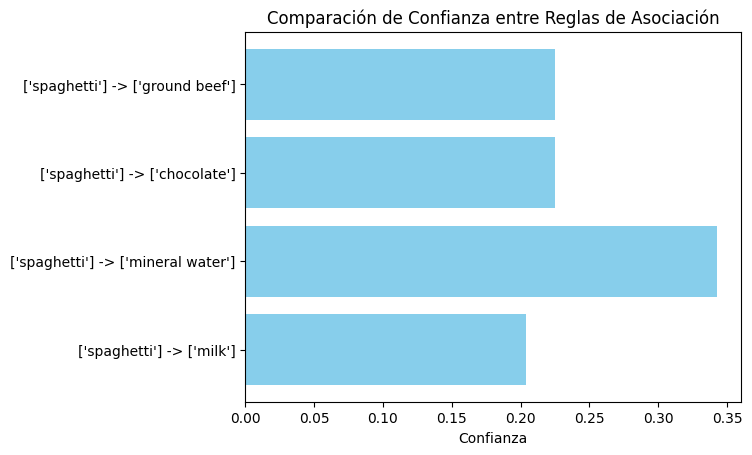

In [ ]:
reglas_umbral['etiqueta'] = reglas_umbral.apply(lambda row: f"{list(row['antecedents'])} -> {list(row['consequents'])}", axis=1)

plt.barh(reglas_umbral['etiqueta'], reglas_umbral['confidence'], color='skyblue')
plt.xlabel('Confianza')
plt.title('Comparación de Confianza entre Reglas de Asociación')
plt.show()

Viendo el gráfico, vemos claramente que lo que, con una confianza de 0.35 spaghetti -> mineral water, es decir, si compras spaghettis entonces, con una confianza del 35%, comprarás mineral water.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



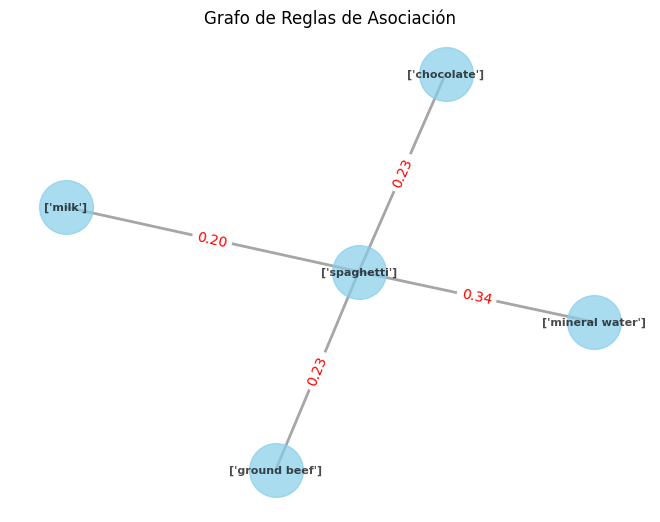

In [ ]:
G = nx.Graph()

# Agregar nodos y conexiones al grafo
for idx, row in reglas_umbral.iterrows():
    antecedents_list = list(row['antecedents'])
    consequents_list = list(row['consequents'])

    G.add_node(str(antecedents_list))
    G.add_node(str(consequents_list))
    G.add_edge(str(antecedents_list), str(consequents_list), weight=round(row['confidence'], 2))

# Dibujar el grafo
pos = nx.spring_layout(G)  # Puedes ajustar el layout según tus preferencias
nx.draw(G, pos, with_labels=True, font_size=8, node_size=1500, font_color='black', node_color='skyblue', edge_color='gray', width=2, alpha=0.7, font_weight='bold', edge_cmap=plt.cm.Blues)
labels = nx.get_edge_attributes(G, 'weight')
labels_formatted = {edge: f"{weight:.2f}" for edge, weight in labels.items()}  # Formatear el peso
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels_formatted, font_color='red')

plt.title('Grafo de Reglas de Asociación')
plt.show()

Hemos querido representar también las tres reglas definitivas que más confianza tienen:

In [ ]:
umbral_confianza = 0.38

reglas_umbral = itemsets_rules_lift[itemsets_rules_lift['confidence'] >= umbral_confianza]

print("\nReglas que cumplen con el umbral mínimo de confianza:")
reglas_umbral.sort_values("confidence", ascending = False)


Reglas que cumplen con el umbral mínimo de confianza:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
30,(olive oil),(mineral water),0.065733,0.238267,0.027467,0.417850,1.753707,0.011805,1.308483,0.460018
24,(ground beef),(mineral water),0.098267,0.238267,0.040933,0.416554,1.748266,0.017520,1.305576,0.474647
26,(ground beef),(spaghetti),0.098267,0.174133,0.039200,0.398915,2.290857,0.022088,1.373959,0.624888


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



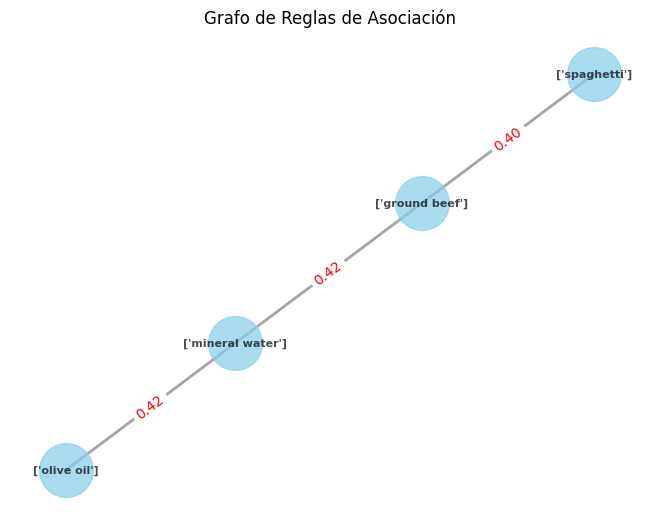

In [ ]:
G = nx.Graph()

# Agregar nodos y conexiones al grafo
for idx, row in reglas_umbral.iterrows():
    antecedents_list = list(row['antecedents'])
    consequents_list = list(row['consequents'])

    G.add_node(str(antecedents_list))
    G.add_node(str(consequents_list))
    G.add_edge(str(antecedents_list), str(consequents_list), weight=round(row['confidence'], 2))

# Dibujar el grafo
pos = nx.spring_layout(G)  # Puedes ajustar el layout según tus preferencias
nx.draw(G, pos, with_labels=True, font_size=8, node_size=1500, font_color='black', node_color='skyblue', edge_color='gray', width=2, alpha=0.7, font_weight='bold', edge_cmap=plt.cm.Blues)
labels = nx.get_edge_attributes(G, 'weight')
labels_formatted = {edge: f"{weight:.2f}" for edge, weight in labels.items()}  # Formatear el peso
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels_formatted, font_color='red')

plt.title('Grafo de Reglas de Asociación')
plt.show()

## **PRÁCTICA 2 (Patronces Secuenciales)**


